[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab9_transfer_learning.ipynb)

# Deep Learning Part 7: Transfer Learning/Fine-Tuning

During training, neural networks often learn features that are useful for a wide variety of tasks. For example, the earliest layers of convolution networks often learn very basic visual features, such as edge detection. These task-agnostic features can be very useful when applied to other tasks. Transfer learning or fine-tuning is a technique that takes a network pretrained on one task and trains it on another. The idea is to tweak or tune the parameters on the new task, rather than making huge changes in learning. Fine-tuning is often quicker than learning on the new task from scratch, and can even lead to better overall performance and generalization.

Unfreezing a pretrained network is a fine-tuning technique that can be helpful when training a network on a difficult task with limited data.
If we allow the network to train its earliest layers immediately, then the earliest layers will forget all of the useful task-agnostic features they learned previously. So, rather than training all of the model weights at once, we learn on the last few layers (which are the most task-specific in the network). We can also gradually start training on the earlier layers as training progresses.

In this section, we will compare unfreezing fine-tuning techniques against training a model from scratch. We will use the large ResNet-152 model to learn the small Bird Species Classification dataset.

In [28]:
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Analyze `BirdDataset`

Start by first downloading the dataset from Kaggle.

#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab.

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [4]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Nov 16 22:39 kaggle.json


3. Copy the desired dataset locally

In [5]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
!kaggle datasets download -d akash2907/bird-species-classification

Dataset URL: https://www.kaggle.com/datasets/akash2907/bird-species-classification
License(s): CC-BY-NC-SA-4.0
 99% 1.36G/1.37G [00:10<00:00, 198MB/s]
100% 1.37G/1.37G [00:10<00:00, 139MB/s]


The `BirdDataset` is implemented for you below. Instantiate a `train_dataset` and `val_dataset`.

In [6]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # We resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
                else:
                    print(f"else {name}")

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

In [7]:
train_dataset = BirdDataset(train=True)
val_dataset = BirdDataset(train=False)

Extracting bird-species-classification.zip
Resizing images


Print out the number of instances of each class in the `train_dataset` and `val_dataset`.

In [8]:
def class_count(dataset):
    # Get the classes and initialize our dictionaries
    classes = dataset.dataset_folder.classes
    class_dict = {i:classes[i] for i in range(len(classes))}
    counts = {classes[i]:0 for i in range(len(classes))}

    # Loop through our datset and count the number of classes
    for i in range(len(dataset)):
        counts[dataset.dataset_folder.classes[dataset[i][1]]] += 1
    return counts, class_dict

train_counts, class_dict = class_count(train_dataset)
val_counts, class_dict = class_count(val_dataset)

print("Training Set")
print(train_counts)
print("\nValidation Set")
print(val_counts)

Training Set
{'blasti': 15, 'bonegl': 6, 'brhkyt': 5, 'cbrtsh': 7, 'cmnmyn': 7, 'gretit': 6, 'hilpig': 10, 'himbul': 18, 'himgri': 20, 'hsparo': 9, 'indvul': 9, 'jglowl': 6, 'lbicrw': 6, 'mgprob': 6, 'rebimg': 10, 'wcrsrt': 10}

Validation Set
{'blasti': 15, 'bonegl': 7, 'brhkyt': 6, 'cbrtsh': 7, 'cmnmyn': 8, 'gretit': 7, 'hilpig': 10, 'himbul': 19, 'himgri': 20, 'hsparo': 9, 'indvul': 9, 'jglowl': 6, 'lbicrw': 6, 'mgprob': 7, 'rebimg': 11, 'wcrsrt': 10}


Print out a single image for each class in a 4x4 display.

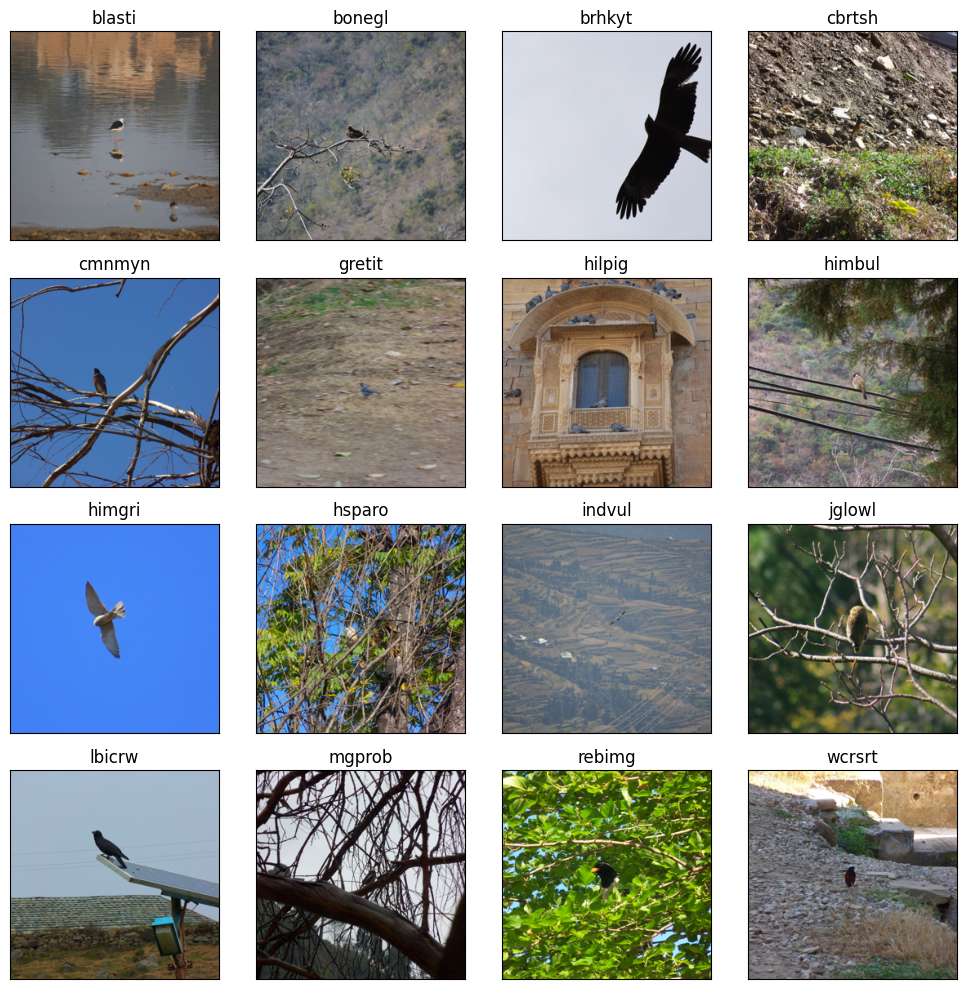

In [9]:
def plot_images(dataset, class_dict):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        j = 0
        while dataset.dataset_folder[j][1] != i:
            j += 1
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title(class_dict[i])
        plt.imshow(dataset.dataset_folder[j][0].permute(1, 2, 0))
    plt.tight_layout()
    plt.show()

plot_images(train_dataset, class_dict)

You will notice that not only do we have a small training dataset (150 images), some of the images are potentially difficult to classify because of how small the bird appears in the image. If you investigated the images further you would notice that many images of a given class are subsequent snapshots of the same bird. This will make generalization hard and overfitting easy, especially with a large network.

## Implement `BirdNet`


Implement the `BirdNet`: a wrapper class adding functionality to a (pretrained) `ResNet`.

### Implement `__init__()`
- The `BirdNet` should first instantiate a `models.resnet152` object and optionally, load in pretrained weights (look at https://pytorch.org/vision/stable/models.html for more information about using pretrained weights). We suggest using `models.ResNet152_Weights.IMAGENET1K_V1`.
- Overwrite the final layer in the ResNet to linearly map (with `nn.Linear`) the previous layers features to `n_classes`.
- Freeze all weights except the final layer. You can do this with calling `.requires_grad = False` on the parameters or calling `.requires_grad(False)` on the layers.


### Implement `unfreeze()`
Implement `unfreeze()` to unfreeze the last `n_layers` of your model. Do not treat the sequential or bottleneck layers in the ResNet as a single layer; we consider a convolutional layer or linear layer as a single layer. You may optionally treat a batchnorm layer as its own layer or as part of a conv/linear layer. ReLU layers do not have parameters, so they can't be frozen/unfrozen.


**Tip**: *You can print out a `models.resnet152` object to get an idea of how many input features are used in the last layer as well as the structure and naming convention used by the ResNet to know how to unfreeze `n_layers`.*


Create a temporary resnet152 model and print it here to see the structure of the network and the naming conventions. You can iterate over `.named_parameters()` to get the name and parameter object, respectively, to verify the naming scheme. This function can make your unfreezing function simpler.

In [40]:
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# iterate over the model and print out the parameter names
for name, param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [71]:
class BirdNet(nn.Module):
    def __init__(self, n_classes, pretrained_weights):
        super().__init__()
        self.net = models.resnet152(weights=pretrained_weights)
        self.net.fc = nn.Linear(self.net.fc.in_features, n_classes)

        # freeze all weights except the last layer
        for param in self.net.parameters():
            param.requires_grad = False
        for param in self.net.fc.parameters():
            param.requires_grad = True


    def unfreeze(self, n_layers):
        # Initialize a counter at 0 and loop through the named modules
        current_n = 0
        for name, module in reversed(list(self.net.named_modules())):

            # Unfreeze parameters if it has any
            if hasattr(module, 'parameters'):
                for param in module.parameters():
                        param.requires_grad = True

            # If it is a linear or convolutional layer, update the counter
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                current_n += 1
                if current_n >= n_layers:
                    break

    def forward(self, x):
        return self.net(x)

## Training

In [72]:
@torch.no_grad()
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()


@torch.no_grad()
def evaluate(model, loss_fn, val_loader):
    val_losses = 0
    val_accs = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()

    for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses += loss_fn(y_hat, y_truth).item() * len(x)
        val_accs += accuracy(y_hat, y_truth) * len(x)

    model.train()
    return val_losses/len(val_dataset), val_accs/len(val_dataset)


Implement the `train()` function. Keep track of the usual performance metrics (training/validation losses and accuracies) and additionally keep track of how long, in seconds, training took (this is referred to as wallclock training time).

There are two additional arguments in `train()`: `slowly_unfreeze` and `unfreeze_interval`.
 If `slowly_unfreeze=True` then for every `unfreeze_interval` number of steps you should unfreeze an additional layer from your model.

In [73]:
def infinite_loader(loader):
    while True:
        for data in loader:
            yield data

def train(model, optimizer, train_loader, val_loader, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval):
    # Initialize our performance lists and our loss function
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    loss_fn = nn.CrossEntropyLoss()
    unfreeze = 0

    # Make a temporary train loss and accuracy list and start the timer
    model.to(device)
    temp_train_loss = []
    temp_train_acc = []
    start = time.time()
    time_list = []

    # Loop through the number of optimization steps and send the batches to our device
    loop = tqdm(total=n_optimization_steps, position=0)
    train_iter = infinite_loader(train_loader)
    for step in range(n_optimization_steps):
        x, y = next(train_iter)
        x, y = x.to(device), y.to(device)

        # Get the prediction
        yhat = model(x)
        loss = loss_fn(yhat, y)

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # append to the temporary training lists
        temp_train_loss.append(loss.item())
        temp_train_acc.append(accuracy(yhat, y))
        loop.set_description('step:{}/{}, loss:{:.4f}'.format(step,n_optimization_steps,loss.item()))
        loop.update()

        # Log if we are at the right interval
        if step % log_interval == 0:
            break_start = time.time()
            train_loss.append(np.mean(temp_train_loss))
            train_acc.append(np.mean(temp_train_acc))
            val_l, val_a = evaluate(model, loss_fn, val_loader)
            val_loss.append(val_l)
            val_acc.append(val_a)

            # Reset the temporary lists
            temp_train_loss = []
            temp_train_acc = []
            break_end = time.time()
            time_list.append(break_end - break_start)

        # Unfreeze if we are at the right interval
        if slowly_unfreeze and step % unfreeze_interval == 0:
            break_start = time.time()
            unfreeze += 1
            model.unfreeze(unfreeze)
            break_end = time.time()
            time_list.append(break_end - break_start)

    # Get the overall time to tain
    end = time.time()
    time_train = end - start - sum(time_list)
    loop.close()

    # Return our performance data
    return train_loss, train_acc, val_loss, val_acc, time_train

To compare how well finetuning works you will perform a set of experiments. There are four models you will train for `n_trials >= 3`:
- `res-reinit`: A reinitialized (not pretrained) resnet model. This is the baseline.
- `res1`: A pretrained resnet model with only the last layer unfrozen.
- `res3`: A pretrained resnet model with the last 3 layers unfrozen.
- `res10-slow`: A pretrained resnet model with the last last 10 layers **slowly** unfrozen.

For each model average the results across the `n_trials` and plot the val accuracy across time for each model and print out the average wallclock time and time per optimization step (i.e. wallclock_time / optimization_step) . **Do not forget to recreate the model and optimizer between each trial.**


**Tip:** Make sure everything is implemented correctly before running all `n_trials` on all four models. We found that a learning rate of .001 worked well for 100 optimization steps.

In [74]:
# Make the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Set the hyperparameters
n_optimization_steps = 150
log_steps = 15
num_unfreeze = 10
lr = .001

# Calculate log_interval and unfreeze_intervall
log_interval = n_optimization_steps // log_steps
unfreeze_interval = n_optimization_steps // num_unfreeze

# Set our models
reinit = BirdNet(16, None).to(device)
res1 = BirdNet(16, models.ResNet152_Weights.IMAGENET1K_V1).to(device)
res3 = BirdNet(16, models.ResNet152_Weights.IMAGENET1K_V1).to(device)
res10_slow = BirdNet(16, models.ResNet152_Weights.IMAGENET1K_V1).to(device)

# Set our optimizers
reinit_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, reinit.parameters()), lr=lr)
res1_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, res1.parameters()), lr=lr)
res3_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, res3.parameters()), lr=lr)
res10_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, res10_slow.parameters()), lr=lr)

In [75]:
# Train the reinitialized model as a control
reinit_train_loss, reinit_train_acc, reinit_val_loss, reinit_val_acc, reinit_time = train(bird_reinit, reinit_optimizer, train_loader, val_loader, n_optimization_steps, log_interval, False, unfreeze_interval)

step:149/150, loss:3.2507: 100%|██████████| 150/150 [00:44<00:00,  3.39it/s]


In [76]:
# Train the res1 model
res1.unfreeze(1)
res1_train_loss, res1_train_acc, res1_val_loss, res1_val_acc, res1_time = train(res1, res1_optimizer, train_loader, val_loader, n_optimization_steps, log_interval, False, unfreeze_interval)

step:149/150, loss:0.9459: 100%|██████████| 150/150 [00:43<00:00,  3.44it/s]


In [77]:
# Train the res3 model
res3.unfreeze(3)
res3_train_loss, res3_train_acc, res3_val_loss, res3_val_acc, res3_time = train(res3, res3_optimizer, train_loader, val_loader, n_optimization_steps, log_interval, False, unfreeze_interval)

step:149/150, loss:0.1535: 100%|██████████| 150/150 [00:44<00:00,  3.40it/s]


In [78]:
# Train the slow model
res10_train_loss, res10_train_acc, res10_val_loss, res10_val_acc, res10_time = train(res10_slow, res10_optimizer, train_loader, val_loader, n_optimization_steps, log_interval, True, unfreeze_interval)

step:149/150, loss:0.4936: 100%|██████████| 150/150 [00:44<00:00,  3.36it/s]


In [92]:
def plot_performance(title, n_steps, train_loss, train_acc, val_loss, val_acc, time_train):
    # Calculate the time per step
    time_per_step = time_train / n_steps
    plt.figure(figsize=(10, 5))
    x_values = np.round(np.arange(0, log_steps)/log_steps * n_steps).astype(int)

    # For the first subplot, show the loss
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(x_values, train_loss, label='train')
    plt.plot(x_values, val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # For the second subplot, show the accuracy
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(x_values, train_acc, label='train')
    plt.plot(x_values, val_acc, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add a title, make it neat, and show the plot
    plt.suptitle(f'{title}\nTime to train: {time_train:.2f}s\nTime per step: {time_per_step:.2f}s')
    plt.tight_layout()
    plt.show()

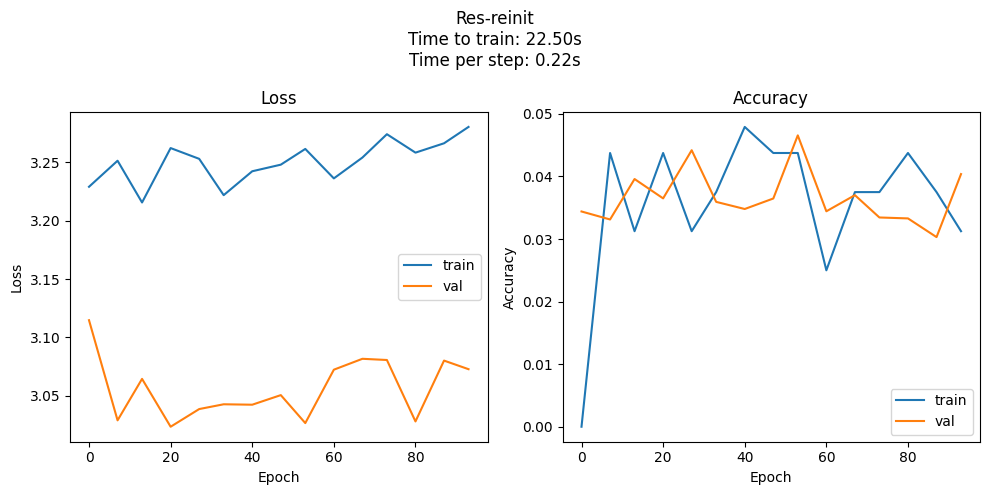

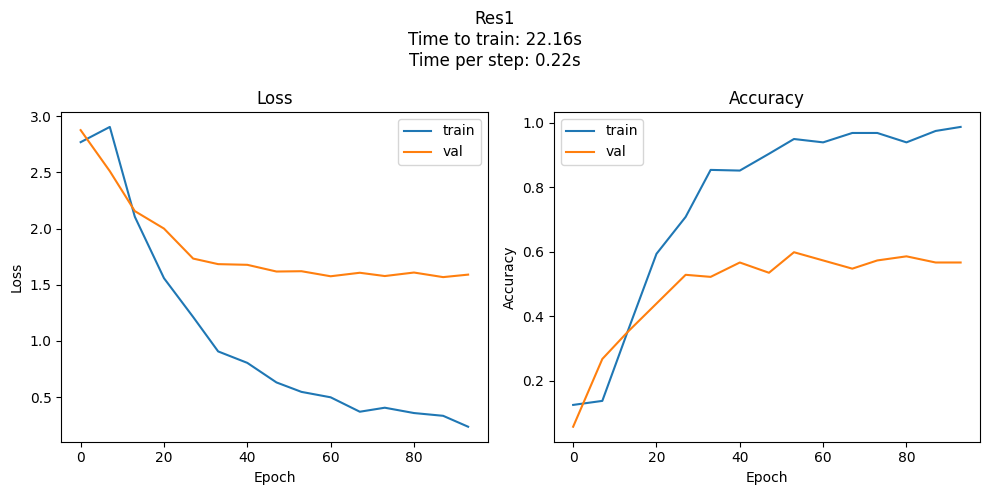

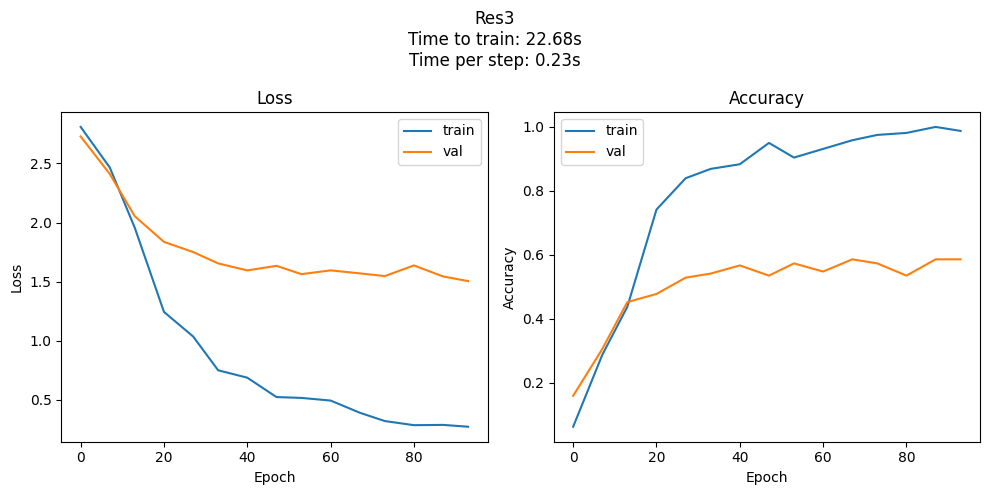

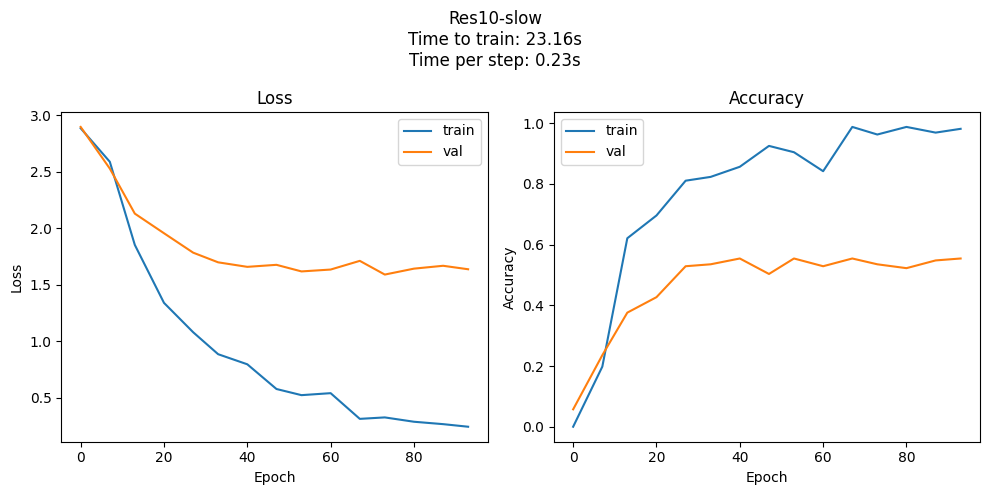

In [106]:
# plot the performances
plot_performance("Res-reinit", 100, reinit_train_loss, reinit_train_acc, reinit_val_loss, reinit_val_acc, reinit_time)
plot_performance("Res1", 100, res1_train_loss, res1_train_acc, res1_val_loss, res1_val_acc, res1_time)
plot_performance("Res3", 100, res3_train_loss, res3_train_acc, res3_val_loss, res3_val_acc, res3_time)
plot_performance("Res10-slow", 100, res10_train_loss, res10_train_acc, res10_val_loss, res10_val_acc, res10_time)

### Questions
- Which model performed the best?
- How do the finetuned models compare to the reinitialized model in terms of time?
- Why are the ImageNet weights helpful to learning the Bird dataset?
- Why do we only unfreeze the last few layers?
- What are some pros and cons of pretraining?


1. The model that performed the best was either res3 or res10-slow, as they had higher overall accuracy and both performances improved faster than res1, and res-init did terrible.

2. The finetuned models took and the reinitialized model took about the same time, with no distinct difference. In theory it should be faster with the frozen models, however it was small enough in this case that my code didn't make a difference. (see training times on the above plots)

3. ImageNet weights are helpful because they already capture general, low-level, visual features, allowing the model to learn the Bird dataset more effectively by utilizing these pretrained weights.

4. We only unfreeze the last few layers to adapt the model to the new dataset while keeping the general features learned by earlier layers, reducing training time and overfitting.

5. Pros: Faster training, improved performance with less data, and resource efficiency. Cons: Less architectural flexibility, potential computational overhead, and risk of negative transfer if pretrained features don't align with the new task.